### 목적
- "LangGraph로 에이전트를 설계할 때 어떻게 생각하고 구조화해야 하는가"에 대한 가이드

#### 프로세스 시작
- 제일 먼저 "노드"의 개념과 역할을 나누어야 한다.
- 각 노드에 대한 결정과 전환을 설명한다.
- 각 노드가 읽고 쓸 수 있는 공유 상태를 통해 노드를 연결한다.

#### 예시) 고객 지원 이메일 처리 AI 에이전트
- 에이전트 역할
    - 수신 고객 이메일 읽기
    - 긴급성과 주제별로 분류
    - 질문에 답하기 위해 관련 문서 검색
    - 적절한 응답 초안 작성
    - 복잡한 문제는 인간 상담원에게 전달
    - 필요할 때 후속 조치를 예약
- 시나리오
    1. 간단한 질문: "비밀번호를 어떻게 재설정하나요?"
    2. 버그 보고서: "PDF 형식을 선택하면 내보내기 기능이 충돌합니다."
    3. 긴급 청구 문제: "구독료가 두 번 청구되었습니다."
    4. 기능 요청: "모바일 앱에 다크 모드를 추가할 수 있나요?"
    5. 복잡한 기술 문제: "API 통합이 간헐적으로 504 오류로 실패합니다."

#### 1. 워크플로우 개별 단계 매핑
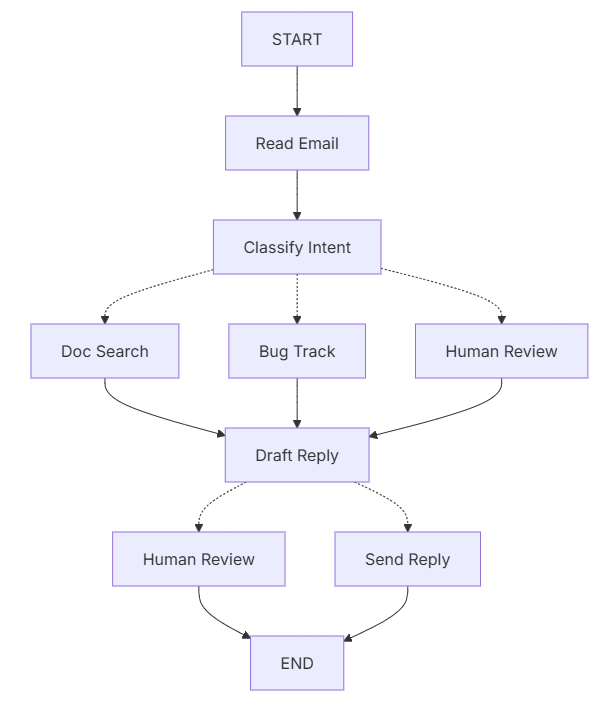
- 각 노드의 역할
    - 이메일 읽기: 이메일 내용 추출 및 구문 분석
    - 의도 분류: LLM을 사용하여 긴급성과 주제를 분류한 다음 적절한 작업으로 라우팅
    - 문서 검색: 관련 정보에 대한 지식 기반을 질문한다.
    - 버그 추적: 추적 시스템에서 문제를 생성하거나 업데이트한다.
    - 초안 답변: 적절한 응답을 생성한다.
    - 인간 검토: 승인 또는 처리를 위해 인간 상담원에게 전달
    - 답장 보내기: 이메일 답장을 발송한다.

#### 2. 각 단계에서 수행할 작업 식별
- 각 노드에 대해 작업 유형과 작동하는 데 필요한 컨텍스트를 확인한다.
    - LLM 단계: 이해, 분석, 텍스트 생성 또는 추론 결정을 내려야 할 때 사용
        - Classify Intent 노드
            - 정적 컨텍스트(프롬프트): 분류 카테고리, 긴급도 정의, 응답 포맷 등
            - 동적 컨텍스트(state): 이메일 본문, 발신자 이메일 
            - 원하는 결과: 라우팅을 결정하는 구조화된 분류
        - Draft Reply 노드
            - 정적 컨텍스트(프롬프트): 톤 가이드라인, 회사 정책, 응답 템플릿
            - 동적 컨텍스트(state): 분류 결과, 검색 결과, 고객 기록 
            - 원하는 결과: 검토를 위한 전문적인 이메일 답변 준비 완료
    - 데이터 단계: 외부 소스에서 정보를 검색해야 할 때 사용
        - Document Search 노드
            - 매개변수: 의도와 주제에서 작성된 쿼리
            - 재시도 전략: 일시적 실패에 대한 백오프 포함
            - 캐싱: API 호출을 줄이기 위해 일반적인 쿼리를 캐싱할 수 있다.
        - 고객 내역 조회
            - 고객 이메일 또는 ID
            - 재시도 전략: 정보를 사용할 수 없을 경우 기본 정보로 대체
            - 캐싱: 신선도와 성능의 균형을 맞추기 위해 TTL(수명)이 적용
    - 조치 단계: 외부 작업을 수행해야 할 때 사용
        - Send Reply 노드
            - 실행 시기: 승인 후(인간 또는 자동화)
            - 재시도 전략: 네트워크 문제에 대한 백오프 포함
            - 각 전송은 고유한 작업이기 때문에 캐싱 금지
        - Bug Track 노드
            - 실행 시기: 항상 의도가 "버그"일 때
            - 재시도 전략: 반드시 성공해야 하므로 재시도 중요
            - 반환: 응답에 포함할 ID
    - 사용자 입력 단계: 인간의 개입이 필요할 때 사용
        - Human Review 노드
            - 결정을 위한 맥락: 원본 이메일, 초안 응답, 긴급성, 분류
            - 예상 입력 형식: 승인 여부와 수정된 답변 텍스트
            - 호출 시기: 긴급도가 높거나, 복잡한 이슈, 품질이 민감한 상황

#### 3. 상태(State) 설계
- 모든 노드가 공유하는 메모리
    - 넣어야 하는 것
        - 여러 단계에 걸쳐 유지되어야 하는지?
    - 저장하지 말아야 할 것
        - 다른 데이터로부터 쉽게 계산이 가능한지?
- 예) 이메일 에이전트에 넣어야 하는 것
    - 원본 이메일/발신자 정보 -> 다시 생성 불가
    - 분류 결과 -> 많은 노드가 사용
    - 검색 결과, 고객 데이터 -> 다시 fetch하기엔 비용이 비쌈
    - draft 응답 -> 검토/수정/발송까지 계속 필요
    - 실행 메타데이터 -> 디버깅/복구용
- State는 raw로 유지, 프롬프트 포맷은 노드에서 해야한다.
    - 같은 데이터를 서로 다른 노드에서 각자 다르게 포맷하여 쓸 수 있음
    - 프롬프트 템플릿을 바꿔도 state 스키마는 고정
    - 디버깅할 때 노드가 받은 데이터를 그대로 볼 수 있음
    - 에이전트가 커져도 state 구조를 깨지 않고 진화 가능


In [240]:
# state 정의
from typing import TypedDict, Literal

# 이메일 분류를 위한 구조 정의
class EmailClassification(TypedDict):
    intent: Literal["question", "bug", "billing", "feature", "complex"]
    urgency: Literal["low", "medium", "high", "critical"]
    topic: str
    summary: str

class EmailAgentState(TypedDict):
    # Raw 데이터
    email_content: str
    sender_email: str
    email_id: str

    # 분류 결과
    classification: EmailClassification | None

    # Raw search/API 결과
    search_results: list[dict] | None 
    customer_history: dict | None

    # 생성된 응답
    draft_response: str | None
    messages: list[dict] | None

#### 4. 노드 구축
- LangGraph의 노드는 현재 state를 받아서 업데이트를 반환하는 Python 함수일 뿐이다.
- 에러를 어떻게 다룰 것인가?

| 에러 종류                                  | 해결 주체   | 처리 전략                            | 사용 시점                             |
| -------------------------------------- | ------- | -------------------------------- | --------------------------------- |
| **일시적 오류** (네트워크 문제, rate limit 등)     | 시스템(자동) | 재시도 정책(Retry policy)             | 재시도로 대부분 해결되는 일시적 실패              |
| **LLM이 스스로 복구 가능한 오류** (툴 실패, 파싱 오류 등) | LLM     | 오류를 state에 저장하고 다시 시도(loop back) | LLM이 오류를 보고 스스로 접근 방식을 조정할 수 있을 때 |
| **사용자가 해결 가능한 오류** (정보 부족, 지시 모호함 등)   | 사용자     | `interrupt()`로 흐름을 멈추고 사용자 입력 대기 | 사용자 추가 정보가 필요할 때                  |
| **예상치 못한 오류**                          | 개발자     | 에러를 그대로 상위로 전달(bubble up)        | 디버깅이 필요한 알 수 없는 오류                |
   


##### 읽기 및 분류 노드

In [241]:
# Read and classify nodes

from typing import Literal
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command, RetryPolicy
# interrupt: 그 시점에서 state를 체크포인터에 저장해두고 실행을 멈추게 함 -> Human-in-the-loop 상황에 적합
## 반드시 checkpointer와 thread_id가 필요
# Command: 런타임에 동적으로 지시하는 명령 객체 -> 어디로 갈지/state를 어떻게 변경할지/interrupt를 재개할지 등
# RetryPolicy: 특정 노드에서 에러가 났을 때 몇 번까지/어떤 간격으로 재시도할지 설정하는 정책 객체
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

llm = ChatOpenAI(model="gpt-5-nano")

def read_email(state: EmailAgentState) -> dict:
    """이메일 내용 추출 및 구문 분석"""
    print("read_email 호출 - 이메일 읽는 중")
    return {
        "messages": [HumanMessage(content=f'처리 중인 이메일: {state["email_content"]}')]
    }

def classify_intent(
    state: EmailAgentState
) -> Command[Literal["search_documentation", "draft_response", "bug_tracking"]]:
    """LLM을 사용하여 이메일 의도와 긴급성을 분류한 다음 그에 따라 라우팅합니다."""
    print("classify_intent 호출 - 이메일 분류 중")
    # EmailClassification 사전을 반환하는 구조화된 LLM
    structured_llm = llm.with_structured_output(EmailClassification)

    classfication_prompt = f"""
    이 고객 이메일에 대해 분석하고 분류하여라:
    Email: {state["email_content"]}
    From: {state["sender_email"]}
    [1] intent (의도) 분류 규칙
    아래 값 중 하나만 선택해서 설정한다.
    - "question" : 기능 사용법, 정책/요금 문의, 단순 정보 요청
    - "bug"      : 오류 신고, 앱/웹이 예상대로 동작하지 않음, 에러 메세지, 접속 불가 등
    - "billing"  : 결제·환불·중복 결제·요금 청구 문제
    - "feature"  : 기능 추가/개선 요청, 건의, 제안
    - "complex"  : 위 범주가 섞여 있거나, 여러 문제가 동시에 포함되어 단일 intent로 보기 어려운 경우

    [2] urgency (긴급성) 분류 규칙
    아래 값 중 하나만 선택한다.

    - "critical":
    - 서비스 사용이 사실상 불가능하거나 데이터/보안/금전 손실 위험이 즉시 존재
    - 예: 로그인·결제가 전혀 안 됨, 대량 결제/중복 결제로 큰 금액이 빠져나감,
            보안 사고·계정 탈취 의심, 법적 리스크가 즉시 발생할 수 있음
    - "high":
    - 빨리 처리해야 하지만 즉시 사고/손실은 아니고, 고객 불만이 강하게 표현된 경우
    - 예: 중요한 업무에 지장을 주는 버그, 반복되는 결제 오류, 강한 항의·불만
    - "medium":
    - 일반적인 수준의 요청/문의/불편 사항. 대부분의 문의는 기본적으로 medium 으로 둔다.
    - "low":
    - 긴급하지 않은 피드백, 단순 건의, 사소한 개선 요청 등

    ※ 중요:
    - 정말 위 기준에 해당하지 않는 한, "critical"은 남용하지 말고,
    애매하면 "medium" 또는 "high"를 사용하라.
    - 고객이 화가 나 있더라도 서비스 중단·보안·금전 위협이 없으면 대부분 "high" 또는 "medium"이다.

    [3] topic (주제)
    - 이메일이 다루는 핵심 주제를 한국어 한 줄로 요약 (예: "구독료 중복 청구 문제", "비밀번호 재설정 방법 문의")

    [4] summary (요약)
    - 이메일 전체 내용을 한국어 1~2문장으로 자연스럽게 요약한다.

    [출력 지침]
    - intent 값은 반드시 ["question", "bug", "billing", "feature", "complex"] 중 하나만 사용한다.
    - urgency 값은 반드시 ["low", "medium", "high", "critical"] 중 하나만 사용한다.
    - topic, summary 는 한국어로 작성한다.
    """

    # 구조화된 응답(dict)를 받기
    classification = structured_llm.invoke(classfication_prompt)

    # 분류에 따라 다음 노드를 결정
    if classification["intent"] in ["question", "feature"]:
        goto = "search_documentation" # 문서 검색으로 라우팅
    elif classification["intent"] == "bug":
        goto = "bug_tracking" # 버그 추적 시스템으로 라우팅
    else:
        goto = "draft_response" # 기타 복잡한 문제는 초안 작성으로 라우팅

    # state의 단일 사전으로 분류 저장
    return Command(
        goto=goto,
        update={"classification": classification}
    )

##### 검색 및 추적 노드

In [242]:
# Search and tracking nodes

def search_documentation(state: EmailAgentState) -> Command[Literal["draft_response"]]:
    """관련 정보를 위해 지식 기반을 검색"""
    print("search_documentation 호출 - 문서 검색 중")
    # 분류에서 검색 쿼리 구축
    classification = state.get("classification", {})
    query = f"{classification.get('intent', '')} {classification.get('topic', '')}"

    try:
        # 여기서 실제 검색 로직을 구현 -> 예: 벡터DB, 외부 API 등
        ## 더미 데이터 사용
        search_results = [
            "설정 > 보안 > 비밀번호 변경을 통해 비밀번호 재설정"
            "비밀번호는 12자 이상이어야 합니다."
            "대문자, 소문자, 숫자, 기호를 포함하세요."
        ]
    except Exception as e:
        search_results = [f"일시적으로 검색을 사용할 수 없습니다. {str(e)}"]

    return Command(
        goto="draft_response", # 검색 후 응답 초안 작성으로 이동
        update={"search_results": search_results}
    )

def bug_tracking(state: EmailAgentState) -> Command[Literal["draft_response"]]:
    """버그 추적 티켓 생성 또는 업데이트"""
    print("bug_tracking 호출 - 버그 티켓 생성 중")
    # 버그 추적 시스템에서 티켓 생성
    ticket_id = "BUG-12345" # 더미 티켓 ID -> 실제 API 호출로 대체

    return Command(
        goto="draft_response", # 티켓 생성 후 응답 초안 작성으로 이동
        update={
            "search_results": [f"버그 티켓이 생성되었습니다: {ticket_id}"],
            "current_step": "bug_ticket"
        }
    )

##### 응답 노드

In [243]:
# Response nodes

def draft_response(state: EmailAgentState) -> Command[Literal["human_review", "send_reply"]]:
    """품질에 따라 컨텍스트와 경로를 사용하여 응답 생성"""
    print("draft_response 호출 - 응답 초안 작성 중")
    classification = state.get("classification", {})

    # 필요에 따라 Raw 상태 데이터에서 컨텍스트 형식 지정
    context_sections = []

    if state.get("search_results"):
        # 프롬프트에 대한 검색 결과 형식 지정
        formatted_docs = "\n".join([f"= {doc}" for doc in state["search_results"]])
        context_sections.append(f"관련 문서: \n{formatted_docs}")

    if state.get("customer_history"):
        # 프롬프트에 대한 고객 데이터 형식 지정
        context_sections.append(f"고객 등급: {state['customer_history'].get('tier', 'standard')}")

    # 형식화된 컨텍스트로 프롬프트를 작성
    draft_prompt = f"""
    이 고객 이메일에 대한 응답 초안을 작성하세요:
    {state["email_content"]}

    Email intent: {classification.get('intent', 'unknown')}
    Urgency level: {classification.get('urgency', 'medium')}

    {chr(10).join(context_sections)} 

    가이드라인:
    - 전문적이고 도움이 되는 태도를 유지하세요.
    - 고객의 구체적인 우려 사항을 해결하세요.
    - 필요한 경우 제공된 문서를 활용하세요."""

    response = llm.invoke(draft_prompt)

    # 긴급성과 의도에 따라 인적 검토가 필요한지 판단합니다.
    needs_review = (
        classification.get("urgency") in ["high", "critical"] or
        classification.get("intent") == "complex"
    )

    # 적절한 다음 노드로의 경로
    goto = "human_review" if needs_review else "send_reply"

    return Command(
        goto=goto,
        update={"draft_response": response.content}
    )

def human_review(state: EmailAgentState):
    """결정에 따라 인터럽트 및 경로를 사용하여 인간 검토를 위한 일시 중지"""
    print("human_review 호출 - 인간 검토 중")
    classification = state.get('classification', {})
    human_decision = interrupt({
        "email_id": state.get('email_id',''),
        "original_email": state.get('email_content',''),
        "draft_response": state.get('draft_response',''),
        "urgency": classification.get('urgency'),
        "intent": classification.get('intent'),
        "action": "Please review and approve/edit this response"
    })

    if human_decision.get("approved"):
        print("인간 검토 승인됨 - 응답 전송 준비")
        return Command(
            goto="send_reply",
            update={"draft_response": human_decision.get("edited_response", state.get("draft_response",""))}
        )
    else:
        # 거부는 인간이 직접 처리한다는 의미
        print("인간 검토 거부됨 - 프로세스 종료")
        return Command(
            goto=END,
            update={}
        )
    
def send_reply(state: EmailAgentState) -> dict:
    """이메일 응답 보내기"""
    print(f"이메일 응답 보냄: {state['draft_response'][:100]}...")
    return {}

##### 노드 연결
- 노드를 연결하여 그래프 생성
- human-in-the-loop를 활성화하려면 실행 간에 상태를 저장하기 위해 checkpointer interrupt()와 함께 컴파일해야 한다.
- 라우팅이 노드 내부에서 Command객체를 통해 이루어지기 때문에 그래프 구조가 최소화 된다.
    - 타입 힌트를 사용하여 이동할 위치를 선언함으로써 흐름을 명확하고 추적 가능하게 만든다. 예시) **Command[Literal["node1", "node2"]]**

In [244]:
# 노드 연결

from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import RetryPolicy

# 그래프 생성
workflow = StateGraph(EmailAgentState)

# 적절한 오류 처리로 노드 추가
workflow.add_node("read_email", read_email)
workflow.add_node("classify_intent", classify_intent)

# 일시적인 오류가 발생할 수 있는 노드에 대한 재시도 정책 추가
workflow.add_node(
    "search_documentation",
    search_documentation,
    retry_policy=RetryPolicy(max_attempts=3)
)
workflow.add_node("bug_tracking", bug_tracking)
workflow.add_node("draft_response", draft_response)
workflow.add_node("human_review", human_review)
workflow.add_node("send_reply", send_reply)

# 필수적인 edge 추가
workflow.add_edge(START, "read_email")
workflow.add_edge("read_email", "classify_intent")
workflow.add_edge("send_reply", END)

# 지속성을 위해 체크포인터로 컴파일
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

##### 그래프 시각화

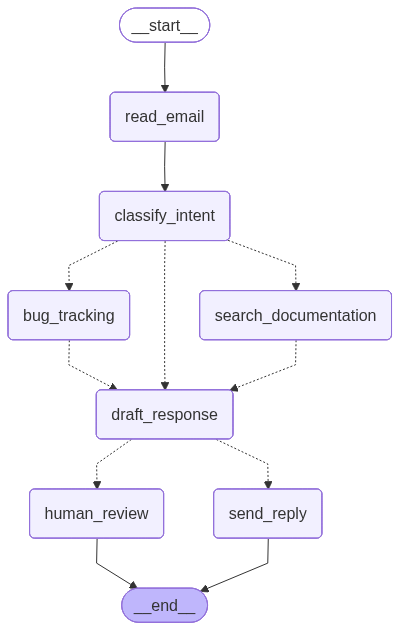

In [245]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

##### 에이전트 실행

In [ ]:
# Test with an urgent billing issue

initial_state = {
    # "email_content": "안녕하세요. 오늘 날씨는 어떤가요?", # 긴급하지 않고, intent가 "question"인 이메일 -> Human review를 거치지 않고 바로 응답 전송으로 감
    "email_content": "구독료가 두 번이나 청구되었습니다! 긴급 상황입니다!",
    "sender_email": "customer@example.com",
    "email_id": "email_123",
    "messages": []
}

# 지속성을 위해 thread_id로 실행
config = {"configurable": {"thread_id": "customer_123"}}
result = app.invoke(initial_state, config)
# 그래프는 human_review에서 일시 중지됩니다.
print(f"응답 초안: {result['draft_response'][:100]}...")

# 준비가 되면 재개를 위한 인적 입력을 제공하세요.
from langgraph.types import Command

human_response = Command(
    resume={
        "approved": True,
        # "approved": False, # 승인 거부하면 프로세스 종료
        "edited_response": "이중 결제에 대해 진심으로 사과드립니다. 즉시 환불을 진행했습니다."
    }
)

# 실행 재개
final_result = app.invoke(human_response, config)
print(f"Email sent successfully!")

read_email 호출 - 이메일 읽는 중
classify_intent 호출 - 이메일 분류 중
draft_response 호출 - 응답 초안 작성 중
human_review 호출 - 인간 검토 중
응답 초안: 제목: 구독료 이중 청구 건에 대한 긴급 처리 안내

안녕하세요, [고객 이름]님.

먼저 구독료가 두 번 청구된 문제로 불편을 드려 진심으로 사과드립니다. 이건 즉시 해결이 필요...
human_review 호출 - 인간 검토 중
인간 검토 승인됨 - 응답 전송 준비
이메일 응답 보냄: 이중 결제에 대해 진심으로 사과드립니다. 즉시 환불을 진행했습니다....
Email sent successfully!
